In [8]:
import sys
sys.path.append("..")

from app.core.process.modeling import Classifier


In [9]:
import torch
from torch.utils.data.dataset import Dataset, TensorDataset
from torch.utils.data.dataloader import DataLoader
import numpy as np
import pytorch_lightning as pl
import pickle


class DataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir: str = "./", val_props: float = 0.2):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        
        self.positive = None
        self.negative = None
        
        self.train_x = None
        self.train_y = None
        self.val_x = None
        self.val_y = None
        
        self.val_props = val_props
        
    def prepare_data(self):
        with open(f"{self.data_dir}/positive_features.pickle", "rb") as fp:
            self.positive = list(pickle.load(fp).values())
        with open(f"{self.data_dir}/negative_features.pickle", "rb") as fp:
            self.negative = list(pickle.load(fp).values())
        
    def setup(self, stage = ""):
        total_positive = len(self.positive)
        n_positive = int((1 - self.val_props) * total_positive)
        total_negative = len(self.negative)
        n_negative = int((1 - self.val_props) * total_negative)
        
        train_positive_x = self.positive[:n_positive]
        train_negative_x = self.negative[:n_negative]
        train_positive_y = len(train_positive_x) * [1.0]
        train_negative_y = len(train_negative_x) * [0.0]
        self.train_x = torch.from_numpy(np.stack([*train_positive_x, *train_negative_x])).squeeze(1)
        self.train_y = torch.tensor([*train_positive_y, *train_negative_y]).unsqueeze(-1)
        
        
        val_positive_x = self.positive[n_positive:]
        val_negative_x = self.negative[n_negative:]
        val_positive_y = len(val_positive_x) * [1.0]
        val_negative_y = len(val_negative_x) * [0.0]
        
        self.val_x = torch.from_numpy(np.stack([*val_positive_x, *val_negative_x])).squeeze(1)
        self.val_y = torch.tensor([*val_positive_y, *val_negative_y]).unsqueeze(-1)
        
    def train_dataloader(self):
        return DataLoader(TensorDataset(self.train_x, self.train_y), batch_size=self.batch_size, shuffle=True)


    def val_dataloader(self):
        return DataLoader(TensorDataset(self.val_x, self.val_y), batch_size=self.batch_size)


In [10]:
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import BinaryAccuracy

class LitClassifier(pl.LightningModule):
    def __init__(self, lr=1e-4):
        super().__init__()
        self.fc = Classifier(pretrained="pretrained.pth", final=nn.Sigmoid)
        self.lr = lr
        self.train_accuracy = BinaryAccuracy()
        self.val_accuracy = BinaryAccuracy()
        self.accuracy = {"train": self.train_accuracy, "val": self.val_accuracy}
    
    def forward(self, x):
        return self.fc(x)
    
    def common_step(self, batch, batch_idx, phase="train"):
        x, y = batch
        logits = self(x)
        criterion = nn.BCELoss()
        loss = criterion(logits, y)
        
        accuracy = self.accuracy[phase](logits, y)
        
        self.log(f"{phase}_loss", loss, on_step=phase == "train", on_epoch=True, logger=True)
        self.log(f"{phase}_accuracy", accuracy, on_step=phase == "train", on_epoch=True, logger=True)
        return loss
    
    def training_step(self, *args):
        return self.common_step(*args, phase="train")
        
    def validation_step(self, *args):
        return self.common_step(*args, phase="val")
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


In [11]:
dm = DataModule(32)
dm.prepare_data()
dm.setup()


In [12]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

model = LitClassifier(lr=1e-4)

trainer = pl.Trainer(max_epochs=50,
                     gpus=1, 
                     callbacks=[EarlyStopping(monitor="val_loss", mode="min"), checkpoint_callback])
trainer.fit(model, dm)


/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /workspace/backend/app/ml/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type           | Params
--------------------------------------------------
0 | fc             | Classifier     | 200 K 
1 | train_accuracy | BinaryAccuracy | 0     
2 | val_accuracy   | BinaryAccuracy | 0     
--------------------------------------------------
200 K     Trainable params
0         Non-trainable params
200 K     Total params
0.804     Total estimated model params size (MB)


/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower val

Epoch 0:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 21/27 [00:00<00:00, 226.65it/s, loss=0.653, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 217.92it/s, loss=0.653, v_num=0]

Epoch 0, global step 21: 'val_loss' reached 0.64487 (best 0.64487), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 1:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 21/27 [00:00<00:00, 251.61it/s, loss=0.642, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 227.73it/s, loss=0.642, v_num=0]

Epoch 1, global step 42: 'val_loss' reached 0.62930 (best 0.62930), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 2:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 21/27 [00:00<00:00, 218.49it/s, loss=0.62, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 206.20it/s, loss=0.62, v_num=0]

Epoch 2, global step 63: 'val_loss' reached 0.61553 (best 0.61553), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 3:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 21/27 [00:00<00:00, 219.67it/s, loss=0.599, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 206.85it/s, loss=0.599, v_num=0]

Epoch 3, global step 84: 'val_loss' reached 0.59977 (best 0.59977), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 4:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 21/27 [00:00<00:00, 218.32it/s, loss=0.593, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 205.79it/s, loss=0.593, v_num=0]

Epoch 4, global step 105: 'val_loss' reached 0.58608 (best 0.58608), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 5:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 21/27 [00:00<00:00, 218.02it/s, loss=0.577, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 205.08it/s, loss=0.577, v_num=0]

Epoch 5, global step 126: 'val_loss' reached 0.57120 (best 0.57120), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 6:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 21/27 [00:00<00:00, 217.54it/s, loss=0.554, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 205.05it/s, loss=0.554, v_num=0]

Epoch 6, global step 147: 'val_loss' reached 0.55656 (best 0.55656), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 7:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 21/27 [00:00<00:00, 218.01it/s, loss=0.535, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 205.51it/s, loss=0.535, v_num=0]

Epoch 7, global step 168: 'val_loss' reached 0.53987 (best 0.53987), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 8:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 21/27 [00:00<00:00, 219.07it/s, loss=0.535, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 206.06it/s, loss=0.535, v_num=0]

Epoch 8, global step 189: 'val_loss' reached 0.52520 (best 0.52520), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 9:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 21/27 [00:00<00:00, 216.74it/s, loss=0.518, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 204.32it/s, loss=0.518, v_num=0]

Epoch 9, global step 210: 'val_loss' reached 0.51060 (best 0.51060), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 10:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 217.47it/s, loss=0.519, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 205.09it/s, loss=0.519, v_num=0]

Epoch 10, global step 231: 'val_loss' reached 0.49748 (best 0.49748), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 11:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 217.62it/s, loss=0.505, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 205.10it/s, loss=0.505, v_num=0]

Epoch 11, global step 252: 'val_loss' reached 0.48567 (best 0.48567), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 12:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 218.06it/s, loss=0.492, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 206.40it/s, loss=0.492, v_num=0]

Epoch 12, global step 273: 'val_loss' reached 0.47266 (best 0.47266), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 13:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 218.08it/s, loss=0.493, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 205.77it/s, loss=0.493, v_num=0]

Epoch 13, global step 294: 'val_loss' reached 0.46017 (best 0.46017), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 14:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 216.16it/s, loss=0.464, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 203.86it/s, loss=0.464, v_num=0]

Epoch 14, global step 315: 'val_loss' reached 0.44694 (best 0.44694), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 15:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 217.92it/s, loss=0.463, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 205.69it/s, loss=0.463, v_num=0]

Epoch 15, global step 336: 'val_loss' reached 0.43234 (best 0.43234), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 16:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 218.03it/s, loss=0.448, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 205.71it/s, loss=0.448, v_num=0]

Epoch 16, global step 357: 'val_loss' reached 0.42026 (best 0.42026), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 17:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 220.11it/s, loss=0.435, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 207.61it/s, loss=0.435, v_num=0]

Epoch 17, global step 378: 'val_loss' reached 0.40578 (best 0.40578), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 18:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 220.18it/s, loss=0.429, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 207.62it/s, loss=0.429, v_num=0]

Epoch 18, global step 399: 'val_loss' reached 0.39124 (best 0.39124), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 19:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 219.86it/s, loss=0.417, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 206.56it/s, loss=0.417, v_num=0]

Epoch 19, global step 420: 'val_loss' reached 0.37830 (best 0.37830), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 20:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 220.35it/s, loss=0.406, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 207.13it/s, loss=0.406, v_num=0]

Epoch 20, global step 441: 'val_loss' reached 0.36443 (best 0.36443), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 21:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 219.81it/s, loss=0.387, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 207.47it/s, loss=0.387, v_num=0]

Epoch 21, global step 462: 'val_loss' reached 0.35279 (best 0.35279), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 22:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 220.44it/s, loss=0.392, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 207.98it/s, loss=0.392, v_num=0]

Epoch 22, global step 483: 'val_loss' reached 0.34065 (best 0.34065), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 23:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 219.33it/s, loss=0.376, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 207.09it/s, loss=0.376, v_num=0]

Epoch 23, global step 504: 'val_loss' reached 0.33068 (best 0.33068), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 24:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 220.61it/s, loss=0.362, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 208.01it/s, loss=0.362, v_num=0]

Epoch 24, global step 525: 'val_loss' reached 0.31974 (best 0.31974), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 25:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 21/27 [00:00<00:00, 220.25it/s, loss=0.36, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 207.69it/s, loss=0.36, v_num=0]

Epoch 25, global step 546: 'val_loss' reached 0.30790 (best 0.30790), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 26:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 218.84it/s, loss=0.338, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 206.66it/s, loss=0.338, v_num=0]

Epoch 26, global step 567: 'val_loss' reached 0.29418 (best 0.29418), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 27:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 219.33it/s, loss=0.324, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 207.01it/s, loss=0.324, v_num=0]

Epoch 27, global step 588: 'val_loss' reached 0.28266 (best 0.28266), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 28:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 218.08it/s, loss=0.311, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 205.96it/s, loss=0.311, v_num=0]

Epoch 28, global step 609: 'val_loss' reached 0.26784 (best 0.26784), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 29:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 219.48it/s, loss=0.307, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 207.27it/s, loss=0.307, v_num=0]

Epoch 29, global step 630: 'val_loss' reached 0.25269 (best 0.25269), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 30:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 218.87it/s, loss=0.287, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 206.76it/s, loss=0.287, v_num=0]

Epoch 30, global step 651: 'val_loss' reached 0.23796 (best 0.23796), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 31:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 221.14it/s, loss=0.275, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 208.10it/s, loss=0.275, v_num=0]

Epoch 31, global step 672: 'val_loss' reached 0.22046 (best 0.22046), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 32:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 219.29it/s, loss=0.252, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 207.03it/s, loss=0.252, v_num=0]

Epoch 32, global step 693: 'val_loss' reached 0.19673 (best 0.19673), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 33:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 218.14it/s, loss=0.225, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 205.97it/s, loss=0.225, v_num=0]

Epoch 33, global step 714: 'val_loss' reached 0.16998 (best 0.16998), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 34:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 220.11it/s, loss=0.206, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 207.75it/s, loss=0.206, v_num=0]

Epoch 34, global step 735: 'val_loss' reached 0.14465 (best 0.14465), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 35:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 218.72it/s, loss=0.176, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 206.09it/s, loss=0.176, v_num=0]

Epoch 35, global step 756: 'val_loss' reached 0.12407 (best 0.12407), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 36:  78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 21/27 [00:00<00:00, 219.70it/s, loss=0.15, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 207.08it/s, loss=0.15, v_num=0]

Epoch 36, global step 777: 'val_loss' reached 0.10833 (best 0.10833), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 37:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 219.68it/s, loss=0.144, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 207.31it/s, loss=0.144, v_num=0]

Epoch 37, global step 798: 'val_loss' reached 0.09630 (best 0.09630), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 38:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 218.73it/s, loss=0.128, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 206.02it/s, loss=0.128, v_num=0]

Epoch 38, global step 819: 'val_loss' reached 0.08638 (best 0.08638), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 39:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 219.95it/s, loss=0.119, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 207.44it/s, loss=0.119, v_num=0]

Epoch 39, global step 840: 'val_loss' reached 0.07874 (best 0.07874), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 40:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 219.15it/s, loss=0.112, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 206.50it/s, loss=0.112, v_num=0]

Epoch 40, global step 861: 'val_loss' reached 0.07263 (best 0.07263), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 41:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 219.59it/s, loss=0.104, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 207.05it/s, loss=0.104, v_num=0]

Epoch 41, global step 882: 'val_loss' reached 0.06721 (best 0.06721), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 42:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 217.14it/s, loss=0.101, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 205.24it/s, loss=0.101, v_num=0]

Epoch 42, global step 903: 'val_loss' reached 0.06222 (best 0.06222), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 43:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 218.47it/s, loss=0.103, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 206.56it/s, loss=0.103, v_num=0]

Epoch 43, global step 924: 'val_loss' reached 0.05871 (best 0.05871), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 44:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 21/27 [00:00<00:00, 218.18it/s, loss=0.0879, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 44: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 205.99it/s, loss=0.0879, v_num=0]

Epoch 44, global step 945: 'val_loss' reached 0.05473 (best 0.05473), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 45:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 21/27 [00:00<00:00, 217.55it/s, loss=0.0852, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 45: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 205.34it/s, loss=0.0852, v_num=0]

Epoch 45, global step 966: 'val_loss' reached 0.05223 (best 0.05223), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 46:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 21/27 [00:00<00:00, 219.44it/s, loss=0.0735, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 46: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 207.15it/s, loss=0.0735, v_num=0]

Epoch 46, global step 987: 'val_loss' reached 0.04846 (best 0.04846), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 47:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 216.88it/s, loss=0.078, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 204.62it/s, loss=0.078, v_num=0]

Epoch 47, global step 1008: 'val_loss' reached 0.04665 (best 0.04665), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 48:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 21/27 [00:00<00:00, 218.27it/s, loss=0.0737, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 48: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 205.78it/s, loss=0.0737, v_num=0]

Epoch 48, global step 1029: 'val_loss' reached 0.04447 (best 0.04447), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1


Epoch 49:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 21/27 [00:00<00:00, 218.55it/s, loss=0.083, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 205.05it/s, loss=0.083, v_num=0]

Epoch 49, global step 1050: 'val_loss' reached 0.04277 (best 0.04277), saving model to '/workspace/backend/app/ml/checkpoints/best-checkpoint.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 193.55it/s, loss=0.083, v_num=0]


# results for the selected model
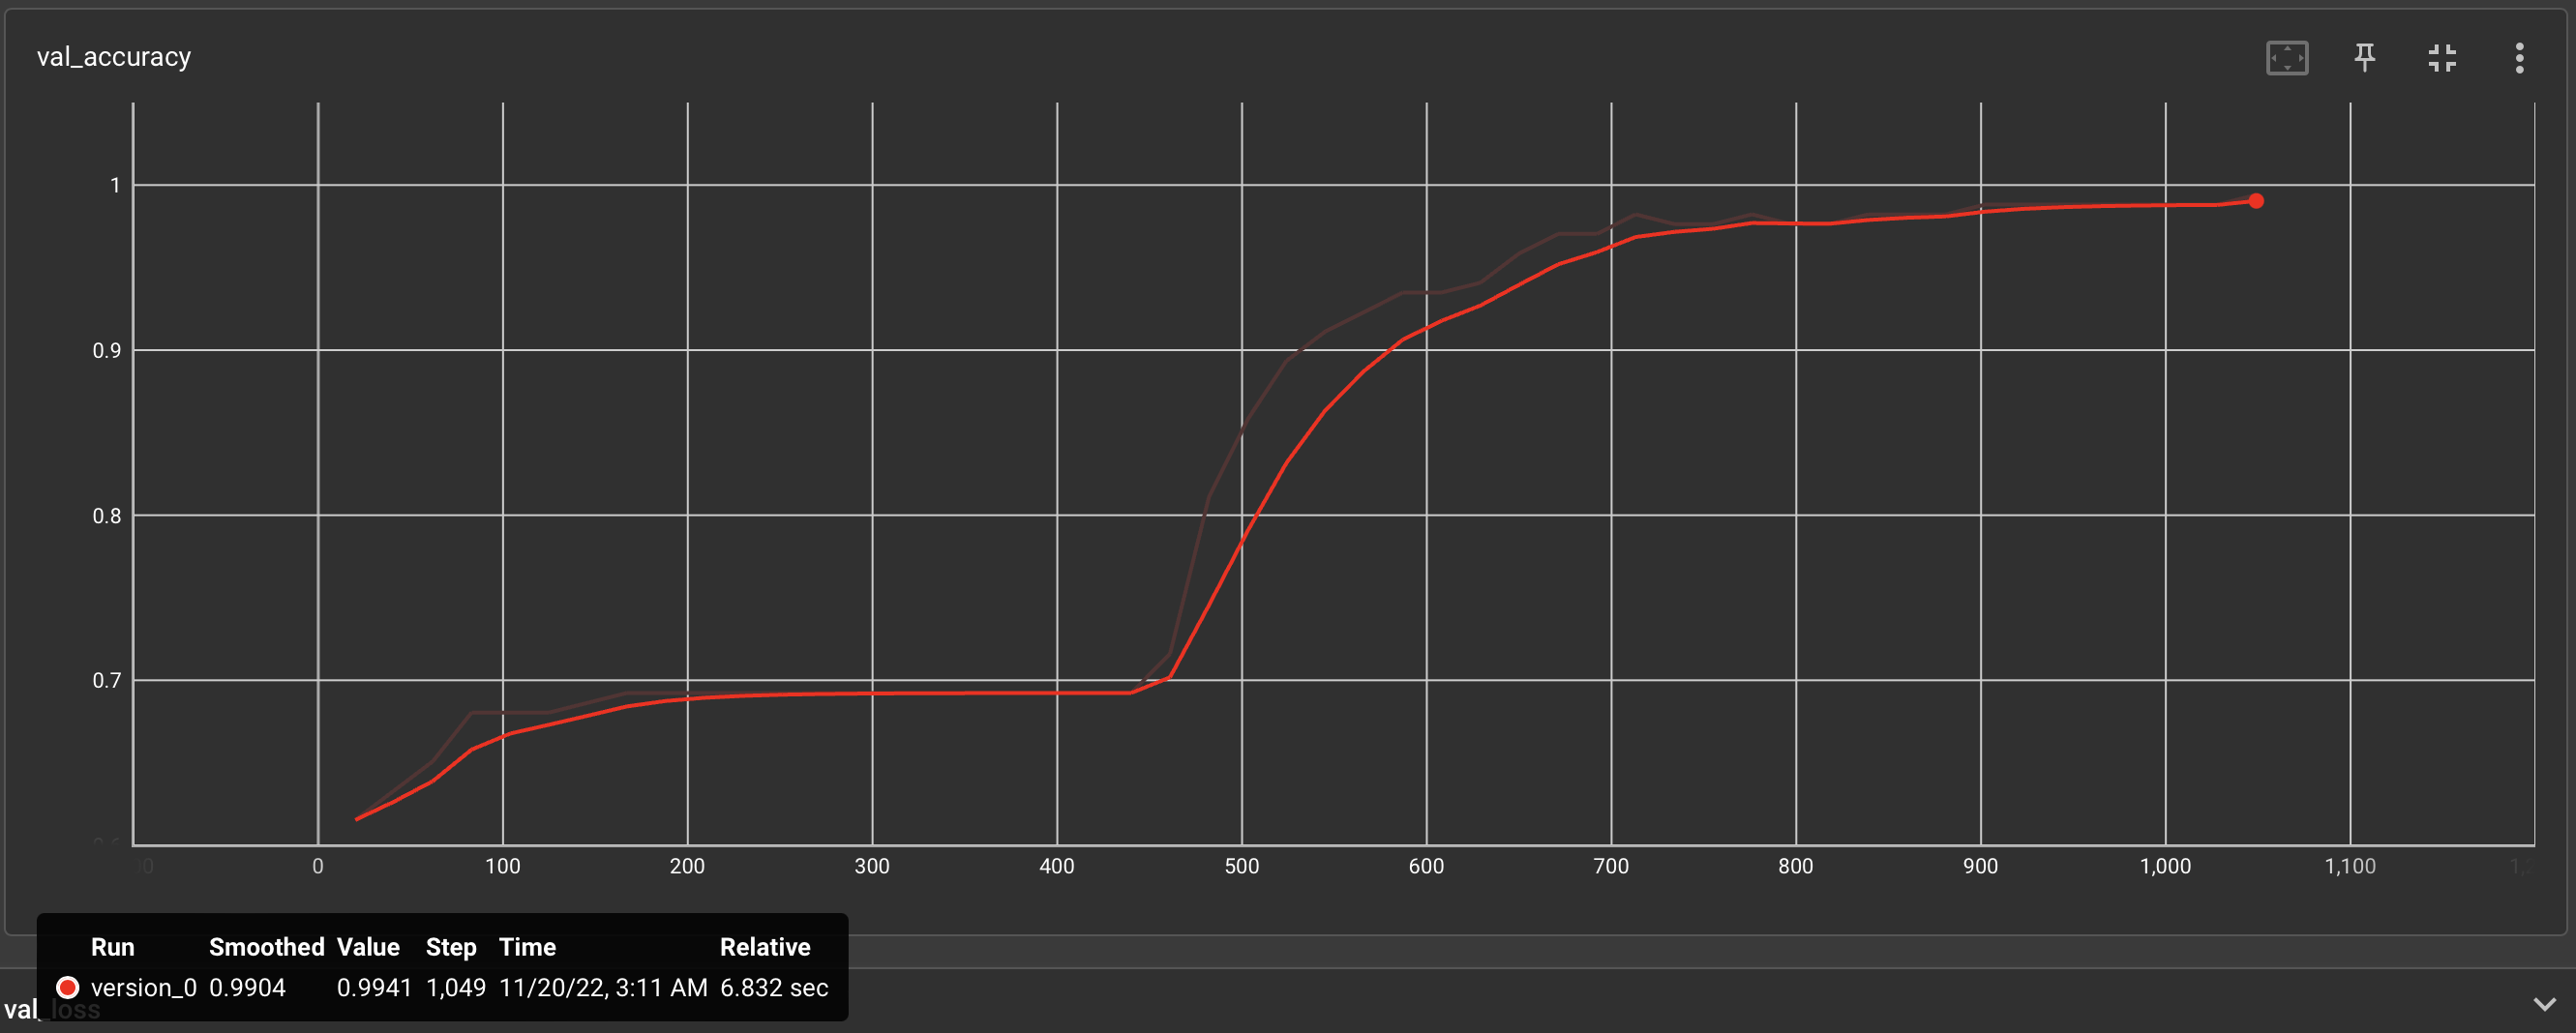


In [17]:
checkpoint = "checkpoints/best-checkpoint.ckpt"

trained = LitClassifier.load_from_checkpoint(checkpoint)
trained.fc.save("../app/core/process/trained/classifier.pth")
